# A small 1D pic without Poisson
To try out the fake R model

In [4]:
#import
import numpy as np
import scipy as sp
import astropy
from imp import reload

import matplotlib.pyplot as plt
%matplotlib inline

import pic

from pic.plasma import plasma
from pic.particles import particles

from pic.functions import generate_maxw, velocity_maxw_flux, max_vect, fux_vect, numba_return_density, smooth
from pic.constantes import (me, q,kb,eps_0,mi)

reload(pic)
reload(pic.plasma)
reload(pic.particles)
reload(pic.functions)
reload(pic.constantes)

import pickle

from ipywidgets import IntProgress as prog
from IPython.display import display
%load_ext snakeviz


The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [14]:
#parameters
Lx = 1e-2 #System length
dX = 0.7e-5 #dX in m
Nx = int(Lx/dX)+2 #cell number
Lx = Nx*dX
print("Nx = {Nx}, and Lx = {Lx} cm".format(Nx = Nx, Lx = Lx*100))

Npart = 60*Nx #particles number, calculated via particle par cell
n = 3e17  #[m^-3]
dT = 3e-12 #time step
Te_0 = 30;     #[eV] Electron distribution temperature
Ti_0 = 5 #[eV]

L_De = np.sqrt(eps_0*Te_0/(q*n))
wpe = np.sqrt(n*q**2/(eps_0*me))

print(f"L_de = {L_De*1e3:2.3f} mm, dX = {dX*1e3} mm")
print(f"time step dT = {dT*1e12:2.2f} mu s, wpe = {wpe**(-1)*1e12:2.2f} mus")

Nx = 1430, and Lx = 1.001 cm
L_de = 0.074 mm, dX = 0.007 mm
time step dT = 3.00 mu s, wpe = 32.36 mus


In [15]:
pla = plasma(dT,Nx,Lx,Npart,n,Te_0,Ti_0,200,0, True)

The initialisation as been validated  !!


59 60


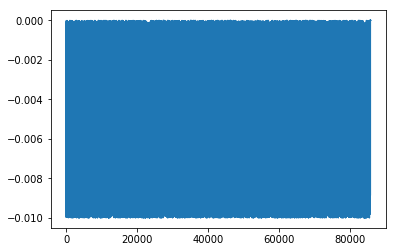

In [16]:
e = pla.ele.remove_parts(pla.Lx-pla.dx)
i = pla.ion.remove_parts(pla.Lx-pla.dx)
#pla.pusher()

plt.plot(pla.ele.x[:]-pla.Lx)


print(e,i)
pla.boundary()
pla.compute_rho()
pla.solve_poisson()
#plt.plot(pla.phi)

In [21]:
%%snakeviz
Nt = 5000
pla.Do_diags = True
pla.n_0 = 0#int(Nt/2)
pla.n_average = 100
pla.data = {}
for nt in np.arange(Nt):
    
    if nt%10 == 0 : print("\r t = {:2.5f} over {:2.5f} mu s".format(nt*pla.dT*1e6,Nt*pla.dT*1e6),end="")
    #if nt%10 == 0 : print("\r t = {} over {} mu s".format(len(pla.ele.x),len(pla.ion.x)),end="")
    pla.pusher()
    pla.boundary()
    pla.compute_rho()
    pla.solve_poisson()
    
    pla.diags(nt)
    
#pla.save_data("tempfile.dat")

 t = 0.01497 over 0.01500 mu s 
*** Profile stats marshalled to file '/tmp/tmps4lbtodx'. 


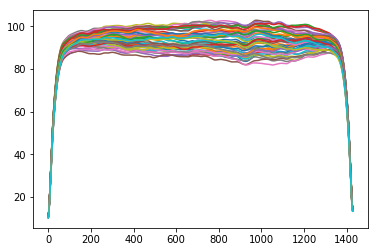

In [22]:
for k,v in pla.data.items():
    plt.plot(smooth(pla.data[k]["phi"][:-1]),label = "Te"+str(k));

    #plt.legend()

0.01001
4.07291885e+18 4.29123695e+18


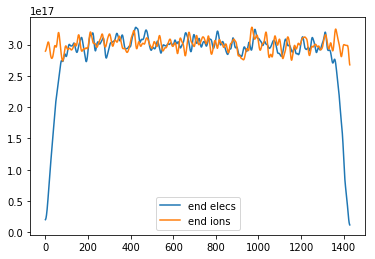

In [19]:
print(pla.Lx)
plt.plot(smooth(pla.ne),label = "end elecs");
plt.plot(smooth(pla.ni),label = "end ions");
plt.legend()
print(pla.ne.sum()*Lx,pla.ni.sum()*Lx)

The initialisation as been validated  !!


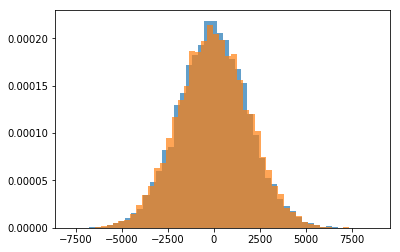

In [12]:
plt.hist(pla.ion.V[:,0],bins=50, alpha = 0.7,density=True);
plainit = plasma(dT,Nx,Lx,Npart,n,Te_0,Ti_0)
plt.hist(plainit.ion.V[:,0],bins=50, alpha = 0.7,density=True);



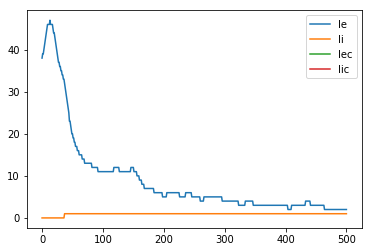

In [18]:
plt.plot(smooth(pla.history["Ie_w"]), label = "Ie")
plt.plot(smooth(pla.history["Ii_w"]), label = "Ii")
plt.plot(smooth(pla.history["Ie_c"]), label = "Iec")
plt.plot(smooth(pla.history["Ii_c"]), label = "Iic")
plt.legend()

In [ ]:
plt.plot(pla.phi)

In [ ]:
plt.hist2d(pla.ele.x,pla.ele.V[:,0],bins=50);

In [ ]:
plt.hist(pla.ion.x,bins = 200);

In [ ]:
plt.plot(pla.phi)

In [ ]:
parts = pla.ele
Nc = 20
for i in np.arange(int(Nx/Nc)):
    j = Nc*i

    mask = (parts.x > pla.x_j[j]) & (parts.x < (pla.x_j[j]+Nc*pla.dx))
    V = parts.V[mask,0]
    hist, bin_edges = np.histogram(V, density= True, bins = 100)
    plt.plot(bin_edges[0:-1],smooth(hist))